In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy.testing import variation

In [2]:
df = pd.read_csv(r"C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\nih-chest-xrays\data\versions\3\Data_Entry_2017.csv")
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


In [3]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [4]:
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800


In [5]:
df['FindingsLabels_Strip'] = df['Finding Labels'].str.split('|')

df_exp = df.copy()
df_exp = df_exp.explode('FindingsLabels_Strip')

In [6]:
view_counts_PA = df['View Position'].value_counts().get('PA', 0)
view_counts_AP = df['View Position'].value_counts().get('AP', 0)
print(f"Total Number of View Positions of PA: {view_counts_PA}")
print(f"Total Number of View Positions of AP: {view_counts_AP}")

Total Number of View Positions of PA: 67310
Total Number of View Positions of AP: 44810


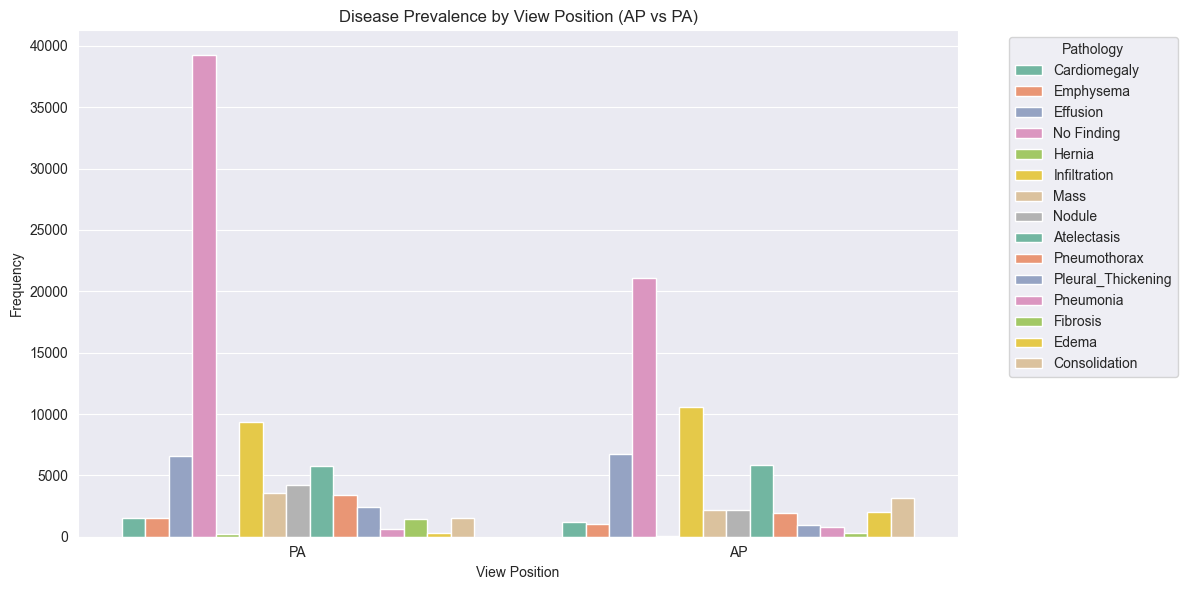

In [7]:
df_pa = df[df['View Position'] == 'PA'].copy()
df_ap = df[df['View Position'] == 'AP'].copy()

plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_exp,
    x='View Position',
    hue='FindingsLabels_Strip',
    palette='Set2'
)

plt.title('Disease Prevalence by View Position (AP vs PA)')
plt.xlabel('View Position')
plt.ylabel('Frequency')
plt.legend(title='Pathology', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('view_position_analysis.png')
plt.show()

In [8]:
rename_map = {
    "OriginalImage[Width": "ImageWidth",
    "Height]": "ImageHeight",
    "OriginalImagePixelSpacing[x": "Pixel(x)",
    "y]": "Pixel(y)"
}

df.rename(columns=rename_map, inplace=True)

In [9]:
def suggest_training_strategy(df):

    total = view_counts_PA + view_counts_AP

    if total == 0:
        return "Error: No AP/PA view positions found."

    pa_ratio = view_counts_PA / total
    ap_ratio = view_counts_AP / total

    if pa_ratio >= 0.6:
        return (
            f"PA-dominant dataset (PA={pa_ratio:.1%}). "
            "Recommendation: Train primarily on PA (gold standard), "
            "use AP for robustness and domain generalization."
        )
    elif ap_ratio >= 0.6:
        return (
            f"AP-dominant dataset (AP={ap_ratio:.1%}). "
            "Warning: High AP prevalence may introduce bedside-device bias. "
            "Consider PA-only validation or view-aware modeling."
        )
    else:
        return (
            f"Balanced dataset (PA={pa_ratio:.1%}, AP={ap_ratio:.1%}). "
            "Recommendation: Use view-position conditioning or stratified sampling."
        )


print("\nTraining Strategy Recommendation:")
print(suggest_training_strategy(df))


Training Strategy Recommendation:
PA-dominant dataset (PA=60.0%). Recommendation: Train primarily on PA (gold standard), use AP for robustness and domain generalization.


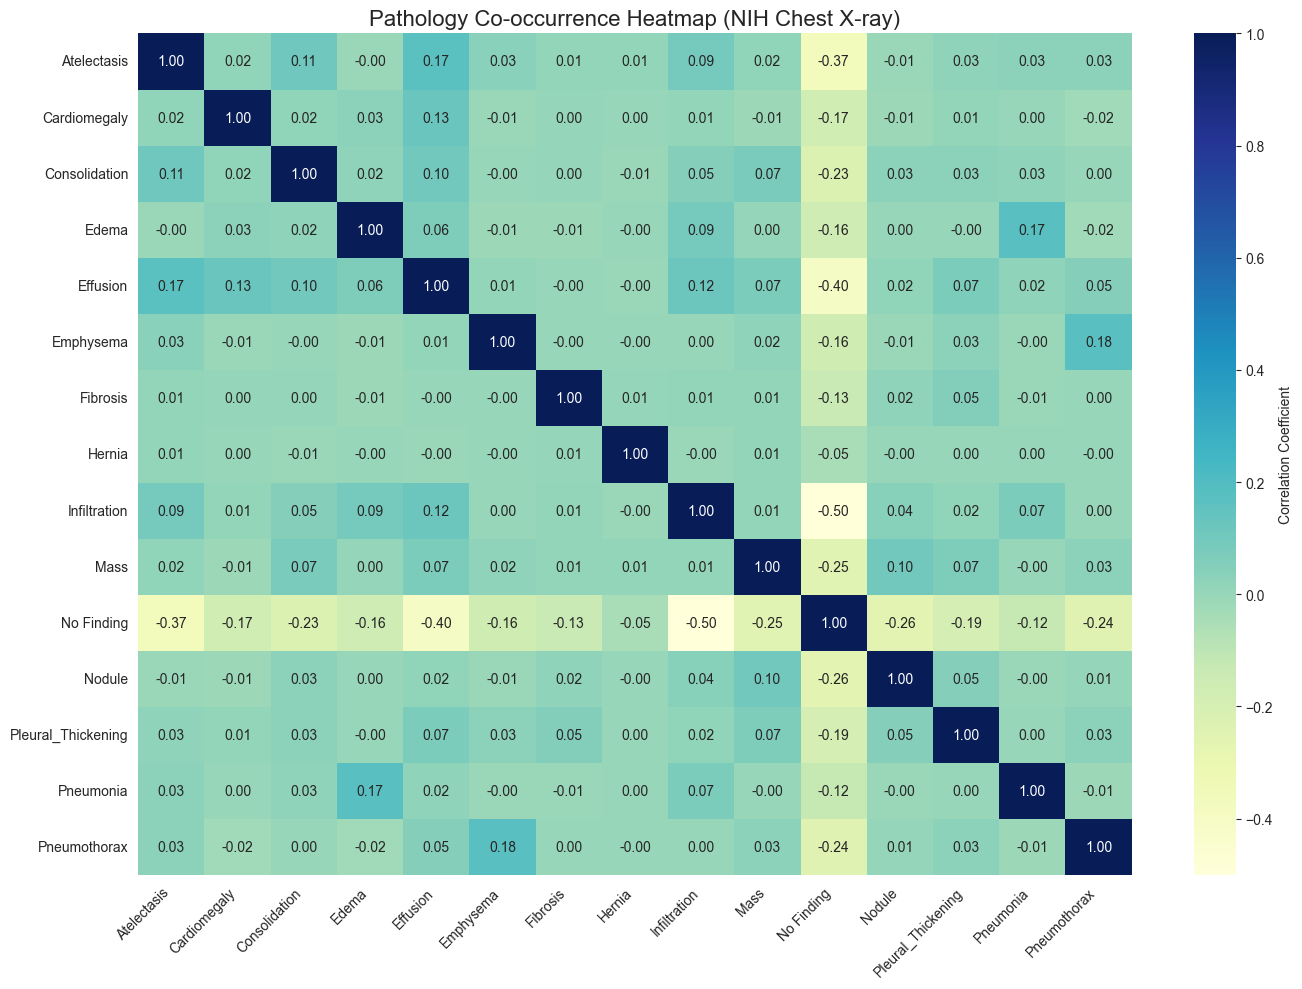

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
label_data = mlb.fit_transform(df['FindingsLabels_Strip'])
one_hot_df = pd.DataFrame(label_data, columns=mlb.classes_)
corr_matrix = one_hot_df.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap='YlGnBu',
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Pathology Co-occurrence Heatmap (NIH Chest X-ray)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

--- Project Insights ---
Total Patients Analyzed: 112120
Detected Minority Class: Hernia (227 cases)

Age/Gender Group most affected by any pathology:
Patient Age     (0, 18]  (18, 40]  (40, 60]  (60, 80]  (80, 100]
Patient Gender                                                  
F                  2546     14163     22269      9409        389
M                  3395     17851     27233     14357        492


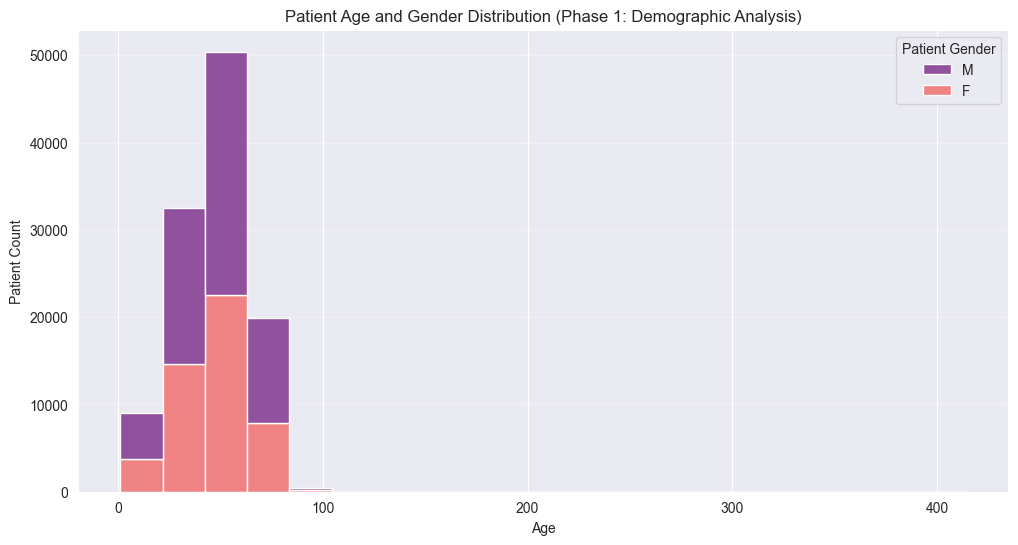

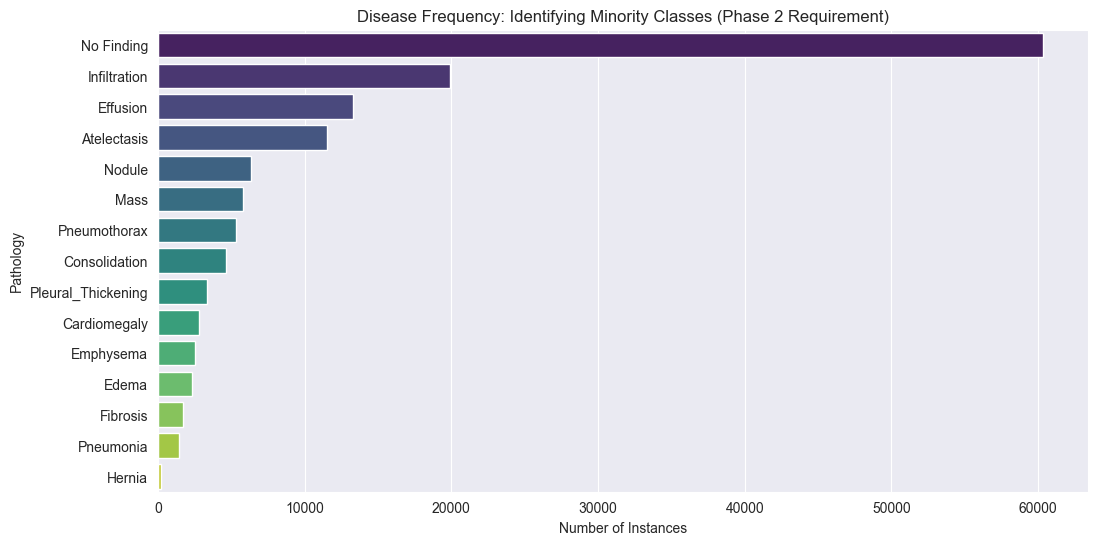

In [11]:
df_age = df[df['Patient Age'] <= 100]
all_labels = df['FindingsLabels_Strip'].explode()
label_counts = all_labels.value_counts()

minority_class = label_counts.index[-1]
minority_count = label_counts.values[-1]

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Patient Age', hue='Patient Gender', multiple="stack", palette='magma', bins=20)
plt.title('Patient Age and Gender Distribution (Phase 1: Demographic Analysis)')
plt.xlabel('Age')
plt.ylabel('Patient Count')
plt.grid(axis='y', alpha=0.3)
plt.savefig('age_gender_dist.png')

plt.figure(figsize=(12, 6))
sns.barplot(
    x=label_counts.values,
    y=label_counts.index,
    hue=label_counts.index,
    palette='viridis',
    dodge=False,
    legend=False
)
plt.title('Disease Frequency: Identifying Minority Classes (Phase 2 Requirement)')
plt.xlabel('Number of Instances')
plt.ylabel('Pathology')
plt.savefig('disease_prevalence.png')

diseased_df = df[df['FindingsLabels_Strip'] != 'No Finding']
age_gender_pivot = (
    diseased_df
    .groupby(
        [
            'Patient Gender',
            pd.cut(
                diseased_df['Patient Age'],
                bins=[0, 18, 40, 60, 80, 100]
            )
        ],
        observed=False
    )
    .size()
    .unstack(fill_value=0)
)

print("--- Project Insights ---")
print(f"Total Patients Analyzed: {len(df)}")
print(f"Detected Minority Class: {minority_class} ({minority_count} cases)")
print("\nAge/Gender Group most affected by any pathology:")
print(age_gender_pivot)

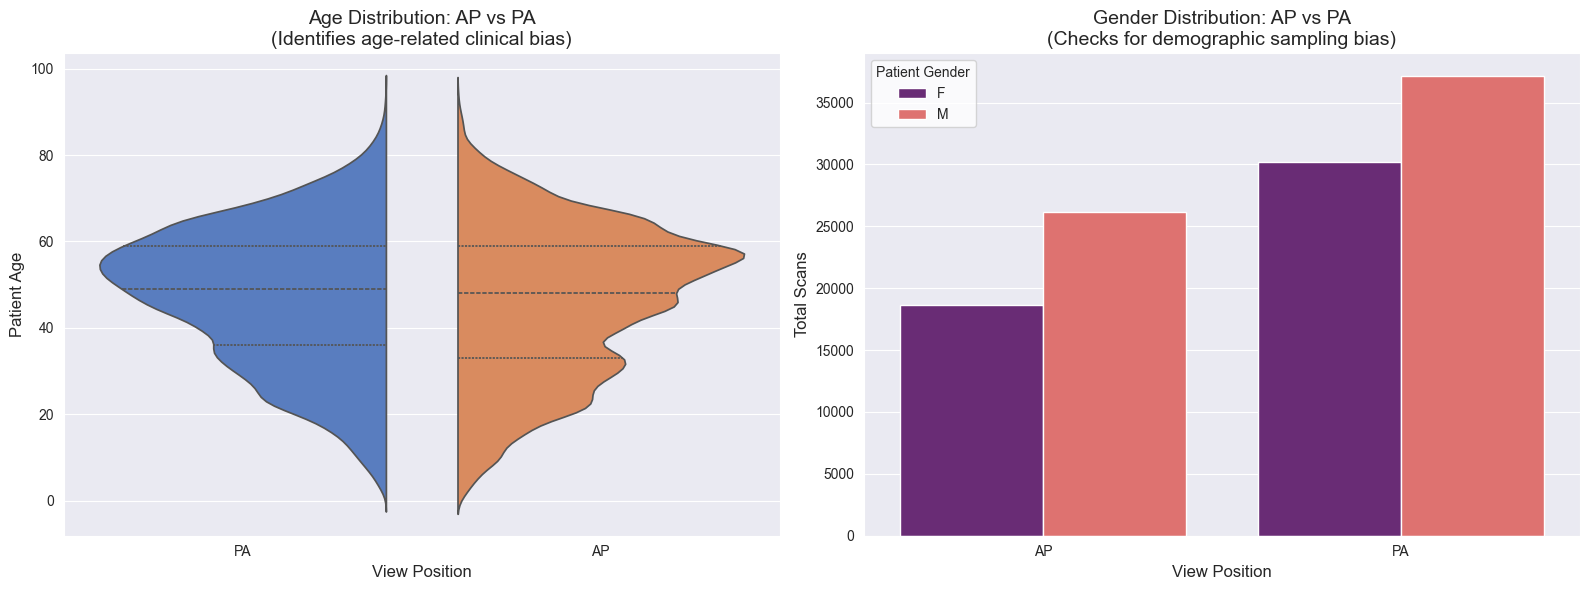

In [12]:
df_clean = df[df['Patient Age'] <= 100].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("whitegrid")

sns.violinplot(ax=axes[0], data=df_clean, x='View Position', y='Patient Age', hue='View Position', palette='muted', split=True, inner="quart")
axes[0].set_title('Age Distribution: AP vs PA\n(Identifies age-related clinical bias)', fontsize=14)
axes[0].set_xlabel('View Position', fontsize=12)
axes[0].set_ylabel('Patient Age', fontsize=12)

gender_view = df_clean.groupby(['View Position', 'Patient Gender']).size().reset_index(name='Count')
sns.barplot(ax=axes[1], data=gender_view, x='View Position', y='Count', hue='Patient Gender', palette='magma')
axes[1].set_title('Gender Distribution: AP vs PA\n(Checks for demographic sampling bias)', fontsize=14)
axes[1].set_xlabel('View Position', fontsize=12)
axes[1].set_ylabel('Total Scans', fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
pa_df = df[df['View Position'] == 'PA']
ap_df = df[df['View Position'] == 'AP']

def get_no_finding_stats(sub_df):
    total = len(sub_df)

    no_finding_count = sub_df[
        sub_df['FindingsLabels_Strip'].apply(
            lambda x: x == ['No Finding']
        )
    ].shape[0]

    percentage = (no_finding_count / total) * 100 if total > 0 else 0
    return total, no_finding_count, percentage

pa_total, pa_no, pa_perc = get_no_finding_stats(pa_df)
ap_total, ap_no, ap_perc = get_no_finding_stats(ap_df)

print(f"{'View Position':<15} | {'Total Images':<15} | {'No Finding Count':<20} | {'Percentage':<10}")
print("-" * 70)
print(f"{'PA (Standard)':<15} | {pa_total:<15} | {pa_no:<20} | {pa_perc:.2f}%")
print(f"{'AP (Portable)':<15} | {ap_total:<15} | {ap_no:<20} | {ap_perc:.2f}%")

# 5. Clinical Correlation Logic (For your USP/Report)
diff = pa_perc - ap_perc
print(f"\nInsight: PA views have a {diff:.2f}% higher 'No Finding' rate than AP views.")

View Position   | Total Images    | No Finding Count     | Percentage
----------------------------------------------------------------------
PA (Standard)   | 67310           | 39302                | 58.39%
AP (Portable)   | 44810           | 21059                | 47.00%

Insight: PA views have a 11.39% higher 'No Finding' rate than AP views.


Original Maximum Age detected:  414


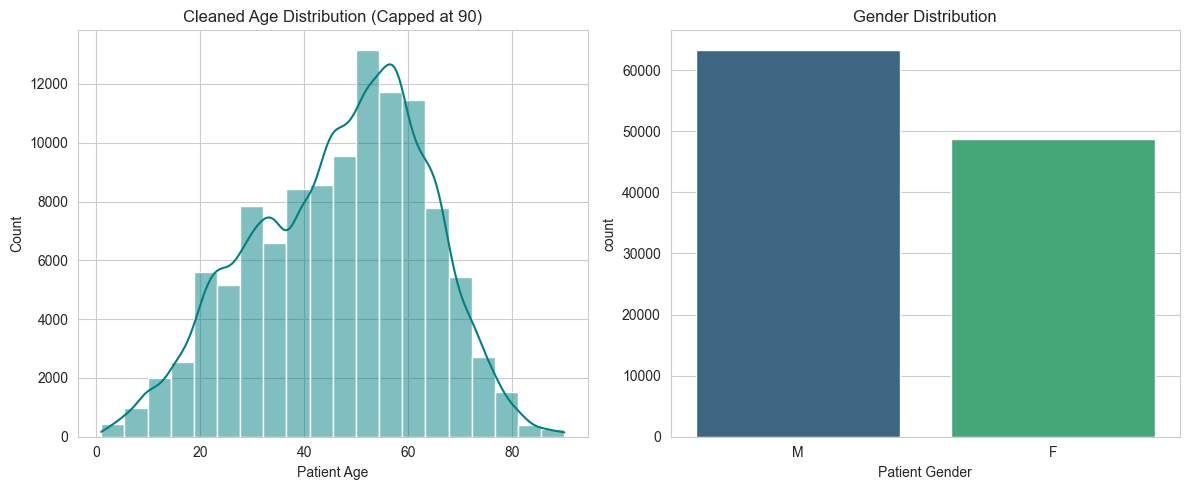

In [14]:
from sklearn.model_selection import GroupShuffleSplit

original_max_age = df['Patient Age'].max()
print(f"Original Maximum Age detected:  {original_max_age}")
df.loc[df['Patient Age'] > 90, 'Patient Age'] = 90

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['Patient Age'], bins=20, kde=True, color='teal')
plt.title("Cleaned Age Distribution (Capped at 90)")
plt.subplot(1,2,2)
sns.countplot(x='Patient Gender', data=df, palette='viridis', hue='Patient Gender')
plt.title('Gender Distribution')
plt.tight_layout()
plt.savefig('demographic_audit_2.png')
plt.show()

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

if isinstance(df['FindingsLabels_Strip'].iloc[0], str):
    df['FindingsLabels_Strip'] = df['FindingsLabels_Strip'].apply(ast.literal_eval)

mlb = MultiLabelBinarizer()
one_hot_labels = mlb.fit_transform(df['FindingsLabels_Strip'])

one_hot_df = pd.DataFrame(one_hot_labels, columns=mlb.classes_)

df_final = pd.concat([df.reset_index(drop=True), one_hot_df], axis=1)

output_path = r'C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\my_dataset\Data_Entry_Final.csv'
df_final.to_csv(output_path, index=False)

print(f"✅ Success! One-hot encoding complete.")
print(f"Total Classes Encoded: {len(mlb.classes_)}")
print(f"Classes: {list(mlb.classes_)}")
print(f"Final file saved at: {output_path}")

# Display the first few rows of the new columns to verify
print("\n--- One-Hot Column Preview ---")
df_final

✅ Success! One-hot encoding complete.
Total Classes Encoded: 15
Classes: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Final file saved at: C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\my_dataset\Data_Entry_Final.csv

--- One-Hot Column Preview ---


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,ImageWidth,ImageHeight,Pixel(x),...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0


### Bounding Box EDA

In [23]:
df_bbox = pd.read_csv(r"C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\nih-chest-xrays\data\versions\3\BBox_List_2017.csv")
df_bbox

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN


In [24]:
df_bbox.describe()

,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
count,984.000000,984.000000,984.000000,984.000000,0.0,0.0,0.0
mean,398.806111,405.425364,256.334708,252.302547,NaN,NaN,NaN
std,222.700868,166.309995,167.629620,159.443635,NaN,NaN,NaN
min,5.417989,12.837934,27.306667,21.617778,NaN,NaN,NaN
25%,203.093333,293.869045,136.533333,115.674074,NaN,NaN,NaN
50%,340.249735,412.850794,214.340942,216.949153,NaN,NaN,NaN
75%,607.959365,521.641995,311.832381,367.902430,NaN,NaN,NaN
max,905.887831,876.980783,901.120000,873.379894,NaN,NaN,NaN


In [26]:
columns_to_drop = df_bbox.columns[-3:]
print(columns_to_drop)
df_bbox.drop(columns=columns_to_drop, inplace=True)
print(df_bbox.shape)
df_bbox

Index(['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], dtype='object')
(984, 6)


,Image Index,Finding Label,Bbox [x,y,w,h]
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695
...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778


In [27]:
rename_map = {
    "Bbox [x": "x",
    "h]": "h",
}
df_bbox.rename(columns=rename_map, inplace=True)
print(df_bbox.columns)

Index(['Image Index', 'Finding Label', 'x', 'y', 'w', 'h'], dtype='object')


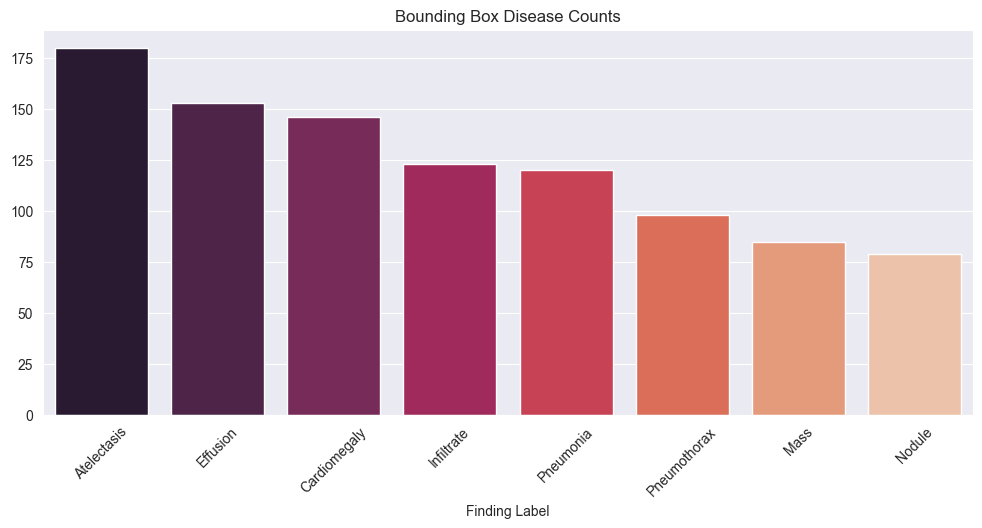

In [29]:
box_findings = df_bbox['Finding Label'].value_counts()

plt.figure(figsize=(12,5))
sns.barplot(x=box_findings.index, y=box_findings.values, hue=box_findings.index, palette='rocket')
plt.xticks(rotation=45)
plt.title("Bounding Box Disease Counts")
plt.show()

                area      aspect
count     984.000000  984.000000
mean    79113.861129    1.227658
std     84525.258083    0.878851
min       845.412749    0.149573
25%     16965.570813    0.748285
50%     47624.186092    1.070473
75%    117544.207117    1.375336
max    584160.395062   10.315789
               count           mean            std            min  \
Finding Label                                                       
Atelectasis    180.0   33508.516887   35363.784028    2154.111684   
Cardiomegaly   146.0  184334.513890   41776.968156  104177.953462   
Effusion       153.0   72002.740565   56833.120498    1739.859437   
Infiltrate     123.0  101381.534391  105084.908345    8181.716713   
Mass            85.0   44378.918083   66393.412615    2271.914667   
Nodule          79.0    5468.771150    3280.365224     845.412749   
Pneumonia      120.0   98815.917503  108415.642994    9341.388168   
Pneumothorax    98.0   54644.573347   49980.638056    1359.265185   

            

C:\Users\gamer\AppData\Local\Temp\ipykernel_20176\3538388088.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


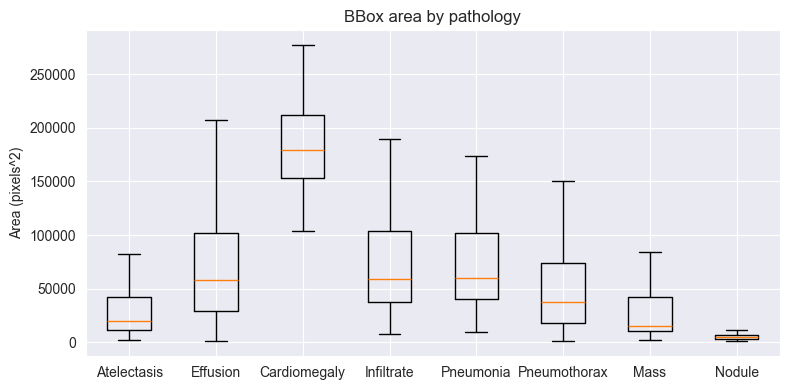

In [30]:
import numpy as np

# Compute area and aspect ratio
df_bbox['area'] = df_bbox['w'] * df_bbox['h']
df_bbox['aspect'] = df_bbox['w'] / df_bbox['h']

print(df_bbox[['area', 'aspect']].describe())

# Per-label area distribution
area_by_label = df_bbox.groupby('Finding Label')['area'].describe()
print(area_by_label)

# Boxplot of area by label
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

# To keep order consistent
labels = df_bbox['Finding Label'].value_counts().index
plt.boxplot(
    [df_bbox[df_bbox['Finding Label'] == lab]['area'] for lab in labels],
    labels=labels,
    showfliers=False
)
plt.ylabel('Area (pixels^2)')
plt.title('BBox area by pathology')
plt.tight_layout()
plt.show()

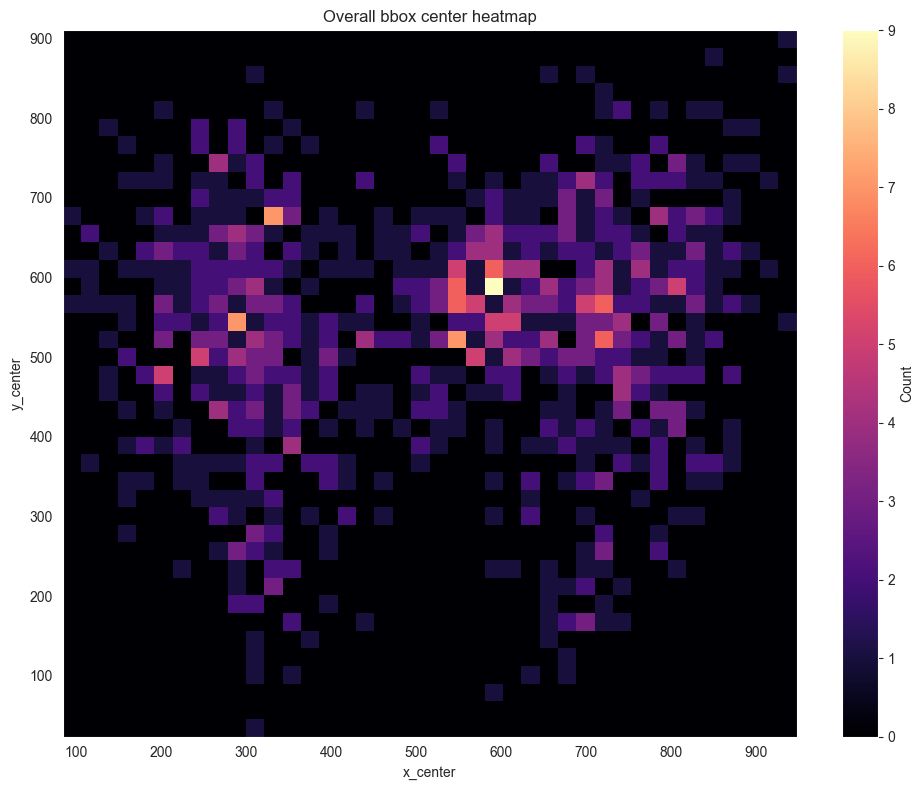

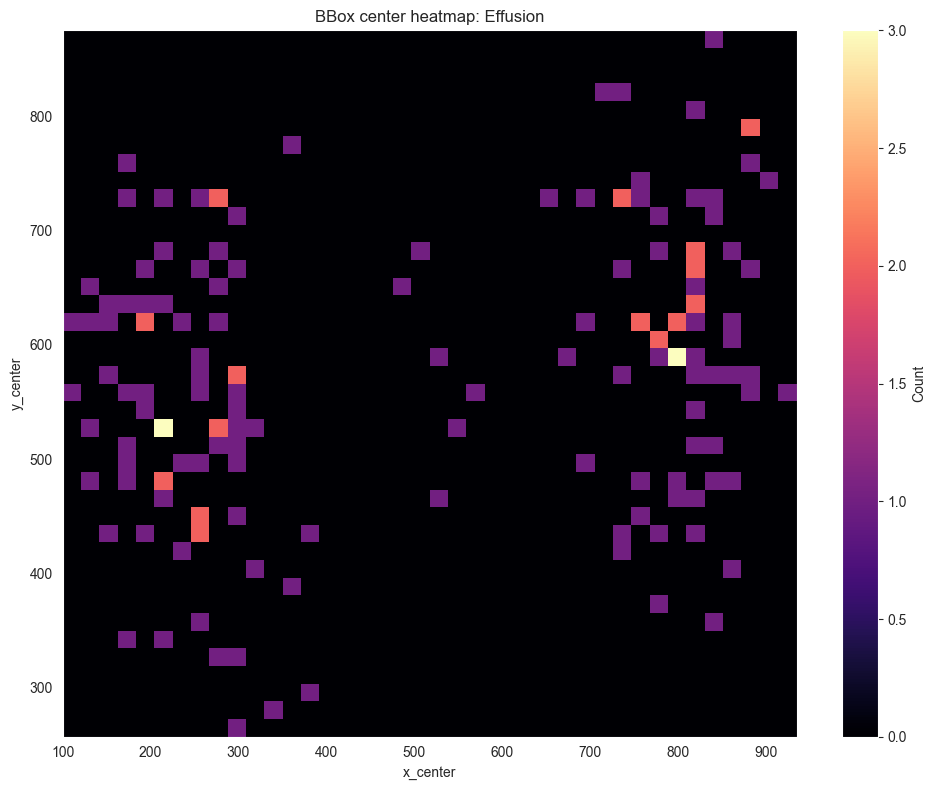

In [31]:
# Compute centers
df_bbox['x_center'] = df_bbox['x'] + df_bbox['w'] / 2
df_bbox['y_center'] = df_bbox['y'] + df_bbox['h'] / 2

# Overall 2D histogram
plt.figure(figsize=(10, 8))
plt.hist2d(df_bbox['x_center'], df_bbox['y_center'], bins=40, cmap='magma')
plt.colorbar(label='Count')
plt.xlabel('x_center')
plt.ylabel('y_center')
plt.title('Overall bbox center heatmap')
plt.tight_layout()
plt.show()

# Per-label example: change label_name as needed
label_name = 'Effusion'
sub = df_bbox[df_bbox['Finding Label'] == label_name]

plt.figure(figsize=(10, 8))
plt.hist2d(sub['x_center'], sub['y_center'], bins=40, cmap='magma')
plt.colorbar(label='Count')
plt.xlabel('x_center')
plt.ylabel('y_center')
plt.title(f'BBox center heatmap: {label_name}')
plt.tight_layout()
plt.show()


In [38]:
one_hot = pd.get_dummies(
    df_bbox['Finding Label'],
    dtype=int
)

df_final = pd.concat(
    [df_bbox.reset_index(drop=True), one_hot],
    axis=1
)

output_path = r'C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\my_dataset\BBox_Final.csv'
df_final.to_csv(output_path, index=False)

print("✅ One-hot encoding (0/1) completed")
print(f"Total Classes: {one_hot.shape[1]}")
print("Classes:", list(one_hot.columns))
df_final

✅ One-hot encoding (0/1) completed
Total Classes: 8
Classes: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Label,x,y,w,h,area,aspect,x_center,y_center,Atelectasis,Cardiomegaly,Effusion,Infiltrate,Mass,Nodule,Pneumonia,Pneumothorax
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,6871.772479,1.095890,268.474576,586.612437,1,0,0,0,0,0,0,0
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,58150.021258,0.591696,778.847458,288.289261,1,0,0,0,0,0,0,0
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,33652.858374,0.715000,299.389831,425.527691,1,0,0,0,0,0,0,0
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,7801.344441,2.549020,796.745763,522.612437,1,0,0,0,0,0,0,0
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,15673.289285,2.569444,760.406780,608.831634,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,198898.038202,1.904930,506.709340,514.465191,1,0,0,0,0,0,0,0
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,6596.967032,1.625000,753.607118,604.349635,1,0,0,0,0,0,0,0
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,25679.755694,2.879518,276.878229,706.180747,1,0,0,0,0,0,0,0
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,25327.641284,2.362637,297.358229,632.225191,1,0,0,0,0,0,0,0


In [39]:
df = pd.read_csv(r"C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\my_dataset\Data_Entry_Final.csv")
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['Patient ID']))
train_df = df.iloc[train_idx].copy()
test_df = df.iloc[test_idx].copy()

train_patients = set(train_df['Patient ID'])
test_patients = set(test_df['Patient ID'])
overlap = train_patients.intersection(test_patients)

print("-" * 30)
print(f"Total Images: {len(df)}")
print(f"Training Images: {len(train_df)} ({len(train_patients)} unique patients)")
print(f"Testing Images: {len(test_df)} ({len(test_patients)} unique patients)")
print(f"Patient ID Overlap: {len(overlap)}")
print("-" * 30)

ROOT = r"C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\my_dataset"
train_df.to_csv(os.path.join(ROOT, 'train_metadata.csv'), index=False)
test_df.to_csv(os.path.join(ROOT, 'test_metadata.csv'), index=False)
print("Splits saved to 'train_metadata.csv' and 'test_metadata.csv'.")

------------------------------
Total Images: 112120
Training Images: 89826 (24644 unique patients)
Testing Images: 22294 (6161 unique patients)
Patient ID Overlap: 0
------------------------------
Splits saved to 'train_metadata.csv' and 'test_metadata.csv'.
